# Sag mir welchen Film ich seh

In diesem Notebook verwenden wir Deep Learning um einen Recommender auf dem MovieLens-Datensatz aufzubauen. Zunaechst laden wir einige Bibliotheken und fixieren Konstanten. Dieses Notebook basiert auf den sehr schönen Vorlagen aus
https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/02_neural_recsys/Explicit_Feedback_Neural_Recommender_System_rendered.ipynb und https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/02_neural_recsys/Implicit_Feedback_Recsys_with_the_triplet_loss_rendered.ipynb

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.contrib.keras.python.keras.layers import  BatchNormalization, Dense, Dropout, Embedding, Flatten, Input
from tensorflow.contrib.keras.python.keras.layers.merge import Add, Concatenate, Dot
from tensorflow.contrib.keras.python.keras.models import Model, Sequential
from tensorflow.contrib.keras.python.keras.optimizers import Adam


from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.manifold import TSNE


#############################################
############FILE PATHS
#############################################
ROOT = '../data/processed/movielens/ml-latest-small'
FEATURE_PATH = '../features/movielens/ml-latest-small'

ROOT = '../../deepLearning/data/processed/movielens/ml-20m'
FEATURE_PATH = '../../deepLearning/features/movielens/ml-20m'

LOG_DIR = '../logs'

#############################################
############PARAMETERS
#############################################
SEED = 42
N_FACTORS = 4
N_SPLITS = 5
LR = 1e-2
BATCH_SIZE = 64


#############################################
############MOVIE AND USER IDS
#############################################

mu_ids = ['movieIdEnc', 'userIdEnc']

Zunaechst laden wir die Filmratings und kodieren Filmtitel und user-ids numerisch.

In [155]:
np.random.seed(SEED)
N_SAMPLE = int(1.5e6)

raw_ratings = shuffle(pd.read_csv('{}/ratings.csv'.format(ROOT)))
ratings = raw_ratings.iloc[:N_SAMPLE, :]
ratings['movieIdEnc'], ratings['userIdEnc'] = [LabelEncoder().fit_transform(ratings[mv]) for mv in ['movieId', 'userId']]

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


For later use, we record the number of movies and users in the ratings set.

In [156]:
[n_mv, n_us] =  

Nun  splitten wir den Datensatz in Trainings- und Validierungsteil auf.

In [157]:
kf = KFold() 
trn, val =  

## Embeddings

Nun definieren wir in Keras eine Funktion zur Einbettung eines Label-encoded-Vektors in einen latenten Raum

In [7]:
def embed(dim, emb_dim):
    """Embed integer vector into latent space
     
    #Arguments
     dim: Anzahl labels in input 
     emb_dim: dimension of latent embedding space
     
    #Returns
     A function that maps input data to the flattened embedding
    """
    emb = Embedding() 
    return Flatten() 

In [57]:
 def dot_prod_model():
    [inp_mv, inp_us] = [Input()] 

    #latent embeddings
    [emb_lat_mv, em_lat_us] = [embed()(inp)] 

    ##compute dot product
    product = Dot()() 

    merged_model = Model([inp_mv, inp_us], product)
    merged_model.compile() 
    
    return merged_model

Jetzt koennen wir das Modell an die Daten fitten.

In [79]:
def fit_model(model, epochs):
    model.fit()

In [90]:
merged_model = dot_prod_model()
fit_model(merged_model, 2)


Train on 400000 samples, validate on 100000 samples
Epoch 1/1
400000/400000 [==============================] - 56s - loss: 9.5391 - val_loss: 4.2695

### Hinzufuegen von Bias

Manche User und manche Filme haben einfach ein per se hoeheres Rating. Deshalbist es sinnvoll Bias-Terme einzufuehren.

In [96]:
 def bias_dot_prod_model():
    [inp_mv, inp_us] = [Input()] 

    #latent embeddings
    [emb_lat_mv, em_lat_us] = [embed()(inp)]

    #bias_embedding embeddings
    [emb_bias_mv, em_bias_us] = [embed()(inp)]

    ##compute dot product
    product = Dot()() 

    ##compute bias sum
    bias_sum = Add()() 

    #biased product
    merged_model = Model([inp_mv, inp_us], bias_sum)

    merged_model.compile()
    return merged_model

In [142]:
merged_model = bias_dot_prod_model()
fit_model(merged_model, 2)

NameError: name 'bias_dot_prod_model' is not defined

## Deep Recommender

Als naechstes ersetzen wir das Skalarprdukt durch ein neurales Netz.

In [110]:
N_HIDDEN = 4

def nnet_model():

    [inp_mv, inp_us] = [Input()] 

    #latent embeddings
    [emb_lat_mv, em_lat_us] = [embed()(inp)] 

    x = Concatenate()() 
    x = Dense()(x)          
    x = Dense(1)(x)

    #define and compile model
    merged_model = Model([inp_mv, inp_us], x)
    merged_model.compile() 
    
    return merged_model, Model(inp_mv, emb_lat_mv)


In [158]:
merged_model, emb_model = nnet_model()
fit_model(merged_model, 1)

Train on 1200000 samples, validate on 300000 samples
Epoch 1/1
1200000/1200000 [==============================] - 262s - loss: 0.8731 - val_loss: 0.8076

## Triplet loss

Nun berechnen wir den Triplet-Loss. Zunaechst sammeln wir nur Ratings oberhalb eines waehlbaren Thresholds auf.

In [ ]:
RATING_THRESHOLD = 4

pos_data_tv = []

Als naechstes samplen wir Triplets mit zufaelligen Negativbeispielen.

In [2]:
def sample_triplets(pos_data, seed = None):
    """Sample negatives at random"""
    np.random.seed(seed)
    
    neg_item_ids = np.random.randint(low = 1, high = n_mv, size = pos_data.shape[0])

    return [pos_data[mi].values for mi in mu_ids[::-1]] + [neg_item_ids]

Nun definieren wir den Triplet-Loss.

In [ ]:
def triplet_loss_function(inputs, margin=1.):
    return tf.maximum(inputs[1] - inputs[0] + margin, 0)

Wir messen die Matching-guete zwischen User-Embedding und Movie-Embedding mit Hilfe eines MLPs

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dense, Dropout, Lambda
import tensorflow as tf

def match_net():
    return Sequential([
        None,
        Dense(1 , activation='relu'),
    ])

Nun definieren wir das eigentliche Triplet-Loss Netz, sowie ein Matching-Netz, dass die Matching-guete zwischen User und Movie zurueckgibt.

In [ ]:
def build_models(n_users, n_items):
    """Build models to train a deep triplet network"""
    inputs = [Input((1,)), Input((1,)), Input((1,))]
    
    emb_layers = []
    
    #Apply embedding layers to unput
    embeddings = []
    
    #pair positive and negative embeddings
    emb_pairs = []

    #compute similarity for matching model
    interaction = mlp()
    similarities = [interaction(emb_pair) for emb_pair in emb_pairs]
    match_model = Model(inputs[:2], similarities[0])

    
    #compute triplet loss for triplet network
    triplet_loss = Lambda()#
    triplet_model = Model(inputs, triplet_loss)
    

    return match_model, triplet_model

Die Modellguete wird durch ein ROC-AUC bewertet

In [ ]:
from sklearn.metrics import roc_auc_score


def average_roc_auc(match_model, data_tv):
    """Compute the ROC AUC for each user and average over users"""
    user_auc_scores = []
    all_item_ids = np.arange(1, n_mv)
    
    for user_id in range(1, n_us ):
        #remove movies from train set and check which movies in test set receive good rating from user
        y_true = None
        
        if np.sum(expected) >= 1:
            # At least one positive test value to rank
            #compute predictions by matching network
            y_pred = match_model.predict()
            user_auc_scores.append(roc_auc_score(y_true, y_pred))

    return np.mean(user_auc_scores)



Nun testen wir das Modell

In [ ]:
deep_match_model, deep_triplet_model= build_models(n_us, n_mv)

def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)
deep_triplet_model.compile(loss=identity_loss, optimizer='adam')

for i in range(2):
    triplet_inputs = sample_triplets(pos_data_tv[0])
    deep_triplet_model.fit(triplet_inputs, np.ones(pos_data_tv[0].shape), shuffle=True, batch_size=64, epochs = 1)

    test_auc = average_roc_auc(deep_match_model, pos_data_tv)
    print(test_auc)

## Filme schauen!

Jetzt visualisieren wir die erzielten Resultate. Zunaechst berechnen wir die Embeddings der Filme.

In [144]:
unique_movies = (ratings[['movieId', 'movieIdEnc']]).drop_duplicates().set_index('movieId')
predicted_embeddings = pd.DataFrame() 
merged_df = predicted_embeddings.merge() 

Als naechstes filtern wir nur die meistgesehensten Filme

In [145]:
movie_counts = ratings.groupby().count() 
top_movies = movie_counts.sort_values() 
relevant_df = merged_df.loc[top_movies.index.values, :].dropna()

Als naechstes bestimmen wir Filmtitel, Rankings und Jahr

In [ ]:
movies = pd.read_csv('{}/movies.csv'.format(ROOT), index_col = 0)
merged_movies = relevant_df.iloc[:,:0].merge(movies) 
avg_ratings = ratings.groupby('movieId')['rating'].mean().to_frame()
avg_rating_movies = merged_movies.merge(ratings.groupby('movieId')['rating'].mean().to_frame())

Ausserdem trennen wir Jahr und Titel

In [ ]:
avg_rating_movies['year'] = avg_rating_movies['title'].apply(lambda x: x[-5:-1]).astype(int)
avg_rating_movies['title'] = avg_rating_movies['title'].apply(lambda x: x[:-7])

## Visualisierung durch Tensorboard

Tensorboard ermoeglicht schicke Visualisierungen von Embeddings. Zunaechst teilen wir Tensorboard mit welches embedding wir betrachten wollen

In [ ]:
embedding_var = tf.Variable(relevant_df.values, name = 'movie_emb')
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

Wir fuegen Filmtitel und Rating als Metadaten hinzu.

In [ ]:
avg_rating_movies[['title', 'rating', 'year']].to_csv('{}/meta.tsv'.format(LOG_DIR), sep = '\t', 
                                              header = True, index = False)
embedding.metadata_path = 'meta.tsv'

Nun exportieren wir die Visualisierungen nach Tensorflow

In [ ]:
summary_writer = tf.summary.FileWriter(LOG_DIR)
projector.visualize_embeddings(summary_writer, config)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
tf.train.Saver().save(sess, '{}/model.ckpt'.format(LOG_DIR), 1)

## Manuelles TSNE -- Obsolet

Nun berechnen wir die TSNE-Projektion der embeddings.

In [165]:
%%time 
tsne = TSNE(n_components = 2, random_state = SEED)
tsne_transformed = pd.DataFrame(tsne.fit_transform(relevant_df.iloc[:,:4] / 5), 
                                columns = ['T0', 'T1'],
                                index = relevant_df.index)

CPU times: user 7.58 s, sys: 460 ms, total: 8.04 s
Wall time: 7.8 s


Als naechstes lesen wir die Filmtitel ein und fuegen diese dem Embedding hinzu.

In [169]:
movies = pd.read_csv('{}/movies.csv'.format(ROOT), index_col = 0)
merged_movies = tsne_transformed.merge(movies) 
avg_ratings = ratings.groupby('movieId')['rating'].mean().to_frame()
avg_rating_movies = merged_movies.merge(ratings.groupby('movieId')['rating'].mean().to_frame())

Wir sehen dass das durchschnittliche Rating auf die Einbettung hat.

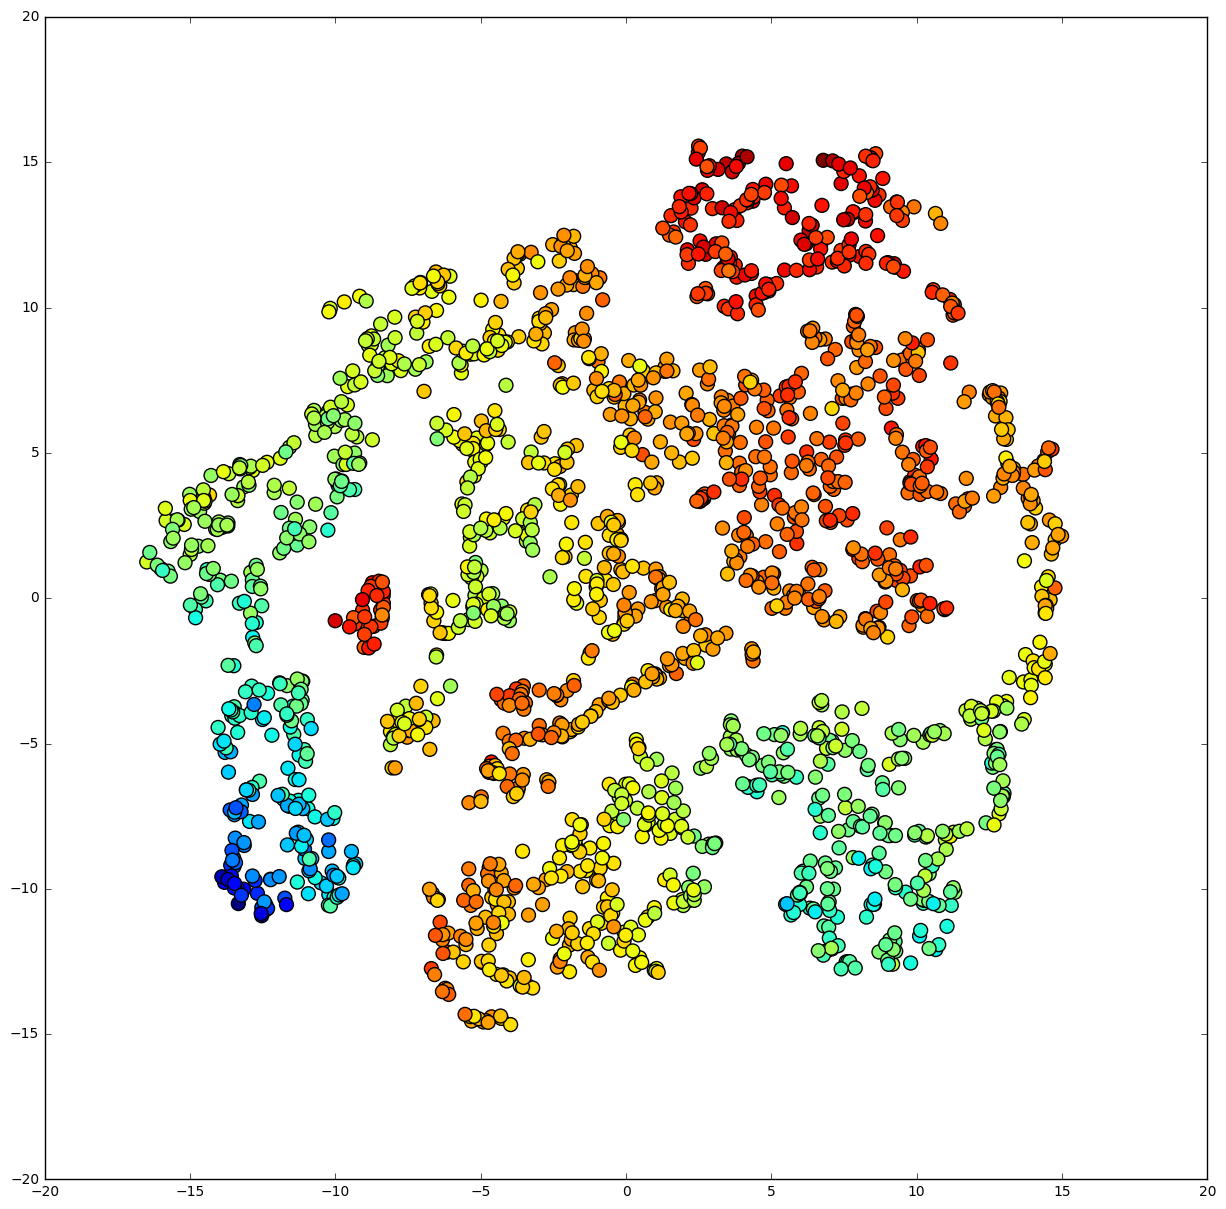

In [170]:
plt.figure(figsize=(15,15))
plt.scatter(None, None, c = avg_rating_movies['rating'], s = 100)#avg_rating_movies['T0'], avg_rating_movies['T1'], )


We are curious about the group on the red group the right -- not clear what happens.

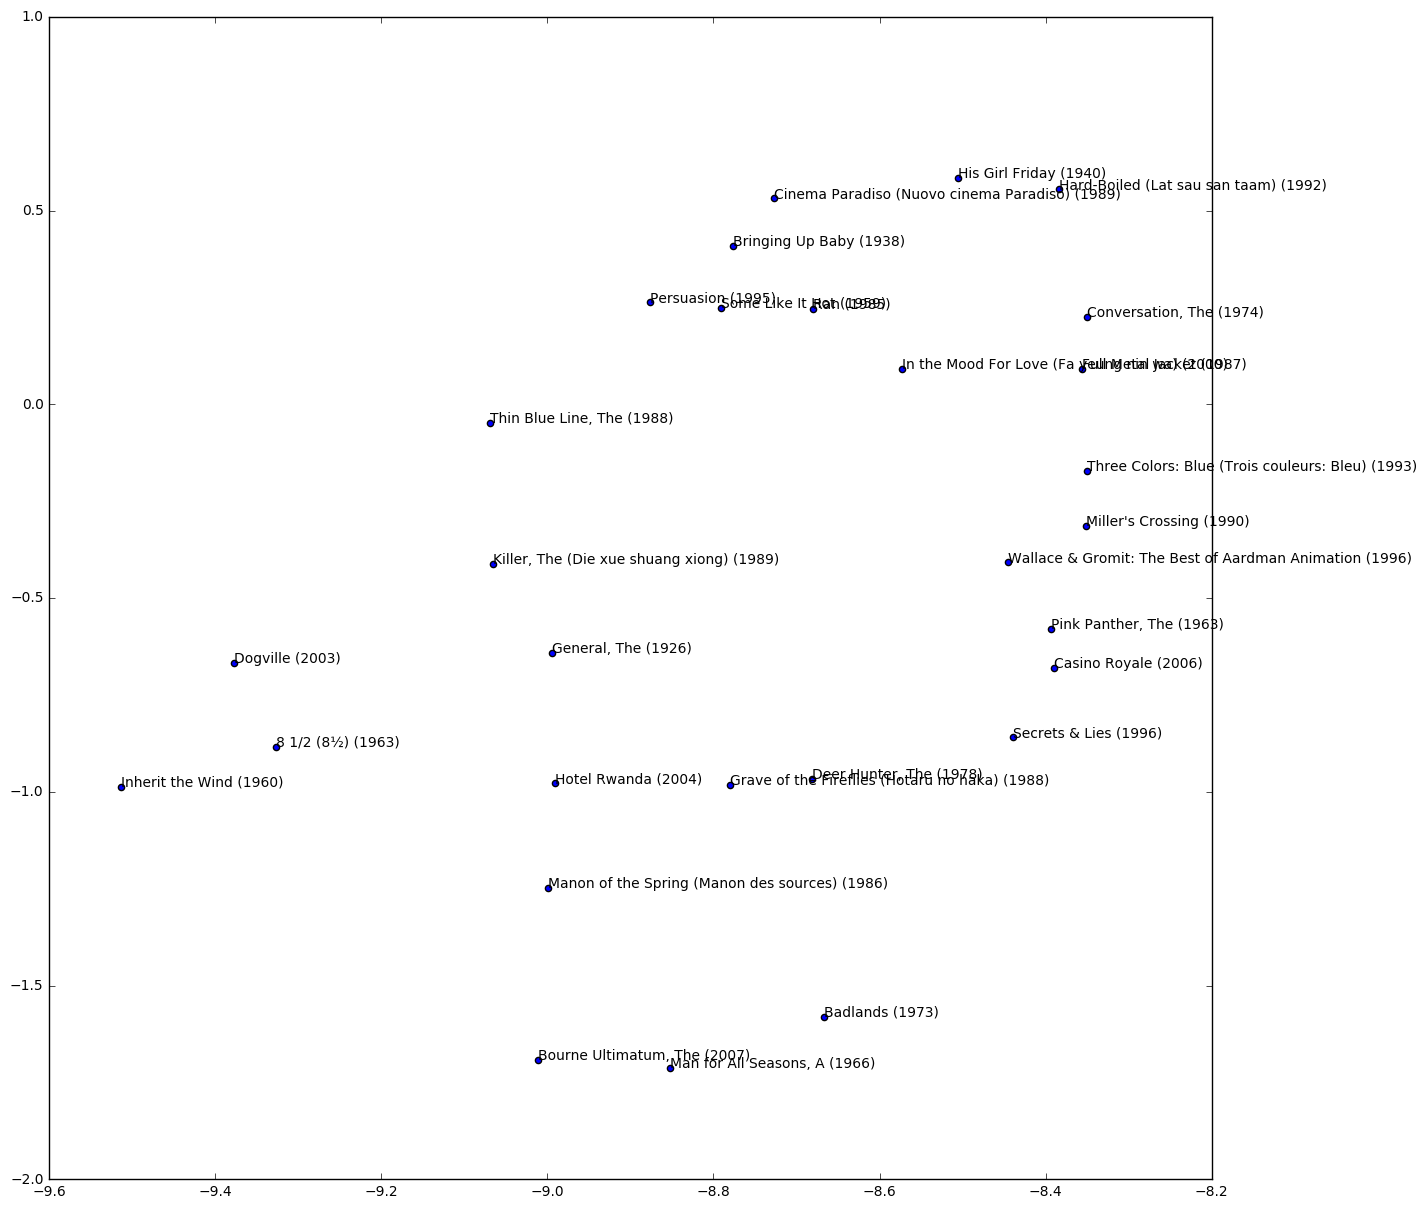

In [177]:
 

plt.figure(figsize=(15,15))
plt.scatter(None, None) 
_ = sub_df.apply(lambda row: plt.text()) 
